# DonorsChoose

In [5]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
import re
import string

import pickle

from tqdm import tqdm
import os

from collections import Counter
from sklearn.model_selection import train_test_split
import sklearn.model_selection as model_selection

from sklearn.metrics import roc_auc_score;
from sklearn.metrics import roc_curve;
from sklearn.linear_model import SGDClassifier;
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

## 1.1 Reading Data

In [6]:
project_data = pd.read_csv('processed_data.CSV');

In [7]:
print('shape of project_data: ', project_data.shape);
print('columns present in project_data: ', project_data.columns)

shape of project_data:  (109248, 16)
columns present in project_data:  Index(['Unnamed: 0', 'id', 'teacher_id', 'school_state',
       'project_submitted_datetime', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'processed_essay',
       'processed_titles', 'processed_grades', 'processed_teacher_prefix',
       'price', 'quantity'],
      dtype='object')


## 1.5 Preparing data for models

In [8]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'school_state',
       'project_submitted_datetime', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'processed_essay',
       'processed_titles', 'processed_grades', 'processed_teacher_prefix',
       'price', 'quantity'],
      dtype='object')

we are going to consider

       - school_state : categorical data
       - clean_categories : categorical data
       - clean_subcategories : categorical data
       - project_grade_category : categorical data
       - teacher_prefix : categorical data
       
       - project_title : text data
       - text : text data
       - project_resource_summary: text data (optinal)
       
       - quantity : numerical (optinal)
       - teacher_number_of_previously_posted_projects : numerical
       - price : numerical

## Importing Glove, pretrained model, which we use for word2vec

In [9]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

<h2>Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [10]:
#splitting project_data into x and y, y=project_is_approved.

#fetching all the columns except project_is_approved.
cols_to_select = [col for col in project_data.columns if col != 'project_is_approved'];
X = project_data[cols_to_select]
print(X.columns)
y = project_data['project_is_approved'];

Index(['Unnamed: 0', 'id', 'teacher_id', 'school_state',
       'project_submitted_datetime', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'clean_categories',
       'clean_subcategories', 'processed_essay', 'processed_titles',
       'processed_grades', 'processed_teacher_prefix', 'price', 'quantity'],
      dtype='object')


In [11]:
#splitting project_data into train and test and CV data.
X_1, X_test, y_1, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)
X_train, X_cv, y_train, y_cv = model_selection.train_test_split(X_1, y_1, test_size=0.3, random_state=1, stratify=y_1);

print('shape of train data ', X_train.shape);
print('shape of test data ', X_test.shape);
print('shape of cross validation data ', X_cv.shape)

shape of train data  (53531, 15)
shape of test data  (32775, 15)
shape of cross validation data  (22942, 15)


In [12]:
train_df = pd.DataFrame();
test_df  = pd.DataFrame();
cv_df    = pd.DataFrame();

<h2>Make Data Model Ready: encoding numerical, categorical features</h2>

## Vectorizing Categorical features

In [13]:
#vectorizing school_state
from sklearn.feature_extraction.text import CountVectorizer


#creating dictionary for school_state as state as keys along with no. of projects from that state as values.
school_state_dict = dict(X_train['school_state'].value_counts());

#configuring CountVectorizer for school state, in which vocabulary will be name of states.
vectorizer = CountVectorizer(vocabulary=list(school_state_dict.keys()), lowercase=False, binary=True);

#applying vectorizer on school_state column to obtain numerical value for each state.
vectorizer.fit(X_train['school_state'].values);

school_state_vector = vectorizer.transform(X_train['school_state'].values);
test_school_state_vector = vectorizer.transform(X_test['school_state'].values);
cv_school_state_vector = vectorizer.transform(X_cv['school_state'].values);

print('shape of matrix after one hot encoding of school_state for train data ', school_state_vector.shape);
print('shape of matrix after one hot encoding of school_state for test data ', test_school_state_vector.shape);
print('shape of matrix after one hot encoding of school_state for cv data ', cv_school_state_vector.shape);

features_name_list = vectorizer.get_feature_names();

shape of matrix after one hot encoding of school_state for train data  (53531, 51)
shape of matrix after one hot encoding of school_state for test data  (32775, 51)
shape of matrix after one hot encoding of school_state for cv data  (22942, 51)


In [14]:
#vectorizing categories

#creating dictionary for categories
from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))


vectorizer = CountVectorizer(vocabulary=list(sorted_cat_dict.keys()), lowercase=False, binary=True);

vectorizer.fit(X_train['clean_categories'].values);

categories_vector = vectorizer.transform(X_train['clean_categories'].values);
test_categories_vector = vectorizer.transform(X_test['clean_categories'].values);
cv_categories_vector = vectorizer.transform(X_cv['clean_categories'].values);

print('shape of matrix after one hot encoding of clean_categories for train data', categories_vector.shape)
print('shape of matrix after one hot encoding of clean_categories for test data', test_categories_vector.shape)
print('shape of matrix after one hot encoding of clean_categories for cv data', cv_categories_vector.shape)

features_name_list.extend( vectorizer.get_feature_names());

shape of matrix after one hot encoding of clean_categories for train data (53531, 9)
shape of matrix after one hot encoding of clean_categories for test data (32775, 9)
shape of matrix after one hot encoding of clean_categories for cv data (22942, 9)


In [15]:
#vectorizing subcategories

my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())
    
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))


vectorizer = CountVectorizer(vocabulary=list(sorted_sub_cat_dict.keys()), lowercase=False, binary=True);

vectorizer.fit(X_train['clean_subcategories'].values);

subcategories_vector = vectorizer.transform(X_train['clean_subcategories'].values);
test_subcategories_vector = vectorizer.transform(X_test['clean_subcategories'].values);
cv_subcategories_vector = vectorizer.transform(X_cv['clean_subcategories'].values);

print('shape of matrix after one hot encoding of clean_subcategories for train data', subcategories_vector.shape)
print('shape of matrix after one hot encoding of clean_subcategories for test data', test_subcategories_vector.shape)
print('shape of matrix after one hot encoding of clean_subcategories for cv data', cv_subcategories_vector.shape)

features_name_list.extend( vectorizer.get_feature_names());

shape of matrix after one hot encoding of clean_subcategories for train data (53531, 30)
shape of matrix after one hot encoding of clean_subcategories for test data (32775, 30)
shape of matrix after one hot encoding of clean_subcategories for cv data (22942, 30)


In [16]:
#vectorizing project_grade_category

grade_dict = dict(X_train['processed_grades'].value_counts());

vectorizer = CountVectorizer(vocabulary=list(grade_dict.keys()), lowercase=False, binary=True);

vectorizer.fit(X_train['processed_grades'].values);

grade_vector = vectorizer.transform(X_train['processed_grades'].values);
test_grade_vector = vectorizer.transform(X_test['processed_grades'].values);
cv_grade_vector = vectorizer.transform(X_cv['processed_grades'].values);

print('shape of matrix after one hot encoding of grade_category for train data', grade_vector.shape)
print('shape of matrix after one hot encoding of grade_category for test data', test_grade_vector.shape)
print('shape of matrix after one hot encoding of grade_category for cv data', cv_grade_vector.shape)

features_name_list.extend( vectorizer.get_feature_names());

shape of matrix after one hot encoding of grade_category for train data (53531, 4)
shape of matrix after one hot encoding of grade_category for test data (32775, 4)
shape of matrix after one hot encoding of grade_category for cv data (22942, 4)


In [17]:
#vectorizing teacher_prefix

teacher_prefix_dict = dict(X_train['processed_teacher_prefix'].value_counts());

vectorizer = CountVectorizer(vocabulary=list(teacher_prefix_dict.keys()), lowercase=False, binary=True);

vectorizer.fit(X_train['processed_teacher_prefix'].values.astype('U'));

teacher_prefix_vector = vectorizer.transform(X_train['processed_teacher_prefix'].values.astype('U'));
test_teacher_prefix_vector = vectorizer.transform(X_test['processed_teacher_prefix'].values.astype('U'));
cv_teacher_prefix_vector = vectorizer.transform(X_cv['processed_teacher_prefix'].values.astype('U'));

print('shape of matrix after one hot encoding of teacher_prefix for train data', teacher_prefix_vector.shape)
print('shape of matrix after one hot encoding of teacher_prefix for test data', test_teacher_prefix_vector.shape)
print('shape of matrix after one hot encoding of teacher_prefix for cv data', cv_teacher_prefix_vector.shape)

features_name_list.extend( vectorizer.get_feature_names());

shape of matrix after one hot encoding of teacher_prefix for train data (53531, 5)
shape of matrix after one hot encoding of teacher_prefix for test data (32775, 5)
shape of matrix after one hot encoding of teacher_prefix for cv data (22942, 5)


## Encoding Numerical data

In [18]:
#vectorizing price

from sklearn.preprocessing import Normalizer

price_normalizer = Normalizer()
#configuring Normalizer 
price_normalizer.fit(X_train['price'].values.reshape(-1, 1));

price_normalized = price_normalizer.transform(X_train['price'].values.reshape(-1, 1))
test_normalized = price_normalizer.transform(X_test['price'].values.reshape(-1, 1))
cv_price_normalized = price_normalizer.transform(X_cv['price'].values.reshape(-1, 1))

features_name_list.append('price');

In [19]:
#vectorizing teacher_number_of_previously_posted_projects

teacher_normalizer = Normalizer();

teacher_normalizer.fit(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1));

teacher_number_normalized = teacher_normalizer.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1));

test_teacher_number_normalized = teacher_normalizer.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1));

cv_teacher_number_normalized = teacher_normalizer.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(-1,1));

features_name_list.append('teacher number of previously posted projects');

In [20]:
#vectorizing quantity:

quantity_normalizer = Normalizer();

quantity_normalizer.fit(X_train['quantity'].values.reshape(-1, 1));

quantity_normalized = quantity_normalizer.transform(X_train['quantity'].values.reshape(-1, 1))

test_quantity_normalized = quantity_normalizer.transform(X_test['quantity'].values.reshape(-1, 1))

cv_quantity_normalized = quantity_normalizer.transform(X_cv['quantity'].values.reshape(-1, 1))

features_name_list.append('quantity');

<h2>Make Data Model Ready: encoding eassay, and project_title</h2>

## Vectorizing using tf-idf

In [21]:
#vectorizing essay

#importing TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

#configuring TfidfVectorizer with a word to occur atleast in 10 documnets.
vectorizer = TfidfVectorizer(min_df=10, ngram_range=(1,2), max_features=5000)

vectorizer.fit(X_train['processed_essay']);

#vectorizing essay using tfidf
essay_tfidf = vectorizer.transform(X_train['processed_essay']);
test_essay_tfidf = vectorizer.transform(X_test['processed_essay']);
cv_essay_tfidf = vectorizer.transform(X_cv['processed_essay']);

print("Shape of matrix after one hot encoding for train data: ",essay_tfidf.shape)
print("Shape of matrix after one hot encoding for test data: ",test_essay_tfidf.shape)
print("Shape of matrix after one hot encoding for cv data: ",cv_essay_tfidf.shape)

Shape of matrix after one hot encoding for train data:  (53531, 5000)
Shape of matrix after one hot encoding for test data:  (32775, 5000)
Shape of matrix after one hot encoding for cv data:  (22942, 5000)


In [22]:
#vectorizing project_title

vectorizer = TfidfVectorizer(min_df=10, ngram_range=(1,2), max_features=5000);

vectorizer.fit(X_train['processed_titles'].astype('U'));

title_tfidf = vectorizer.transform(X_train['processed_titles'].astype('U'));
test_title_tfidf = vectorizer.transform(X_test['processed_titles'].astype('U'));
cv_title_tfidf = vectorizer.transform(X_cv['processed_titles'].astype('U'));

print('Shape of title_tfidf after one hot encoding for train data ', title_tfidf.shape)
print('Shape of title_tfidf after one hot encoding for test data ', test_title_tfidf.shape)
print('Shape of title_tfidf after one hot encoding for cv data ', cv_title_tfidf.shape)

Shape of title_tfidf after one hot encoding for train data  (53531, 5000)
Shape of title_tfidf after one hot encoding for test data  (32775, 5000)
Shape of title_tfidf after one hot encoding for cv data  (22942, 5000)


## Vectorizing using avg w2v on train

In [23]:
#vectorizing essay

essay_avg_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['processed_essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    essay_avg_w2v.append(vector)

#printing number of documents
print(len(essay_avg_w2v))

#printing dimension of each essay avg w2v
print(len(essay_avg_w2v[0]))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 53531/53531 [00:17<00:00, 3127.45it/s]


53531
300


In [24]:
#vectorizing project_title

title_avg_w2v = [];
for sentance in tqdm(X_train['processed_titles'].astype('U')):
    vector = np.zeros(300);
    cnt_words = 0;
    for word in sentance.split():
        if word in glove_words:
            vector += model[word];
            cnt_words += 1;
    if cnt_words != 0:
        vector /= cnt_words;
    title_avg_w2v.append(vector);

print(len(title_avg_w2v));
print(len(title_avg_w2v[0]))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 53531/53531 [00:00<00:00, 113001.90it/s]


53531
300


## Vectorizing using avg w2v on CV

In [25]:
#vectorizing essay

cv_essay_avg_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['processed_essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    cv_essay_avg_w2v.append(vector)

#printing number of documents
print(len(cv_essay_avg_w2v))

#printing dimension of each essay avg w2v
print(len(cv_essay_avg_w2v[0]))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 22942/22942 [00:07<00:00, 3143.85it/s]


22942
300


In [26]:
#vectorizing project_title

cv_title_avg_w2v = [];
for sentance in tqdm(X_cv['processed_titles'].astype('U')):
    vector = np.zeros(300);
    cnt_words = 0;
    for word in sentance.split():
        if word in glove_words:
            vector += model[word];
            cnt_words += 1;
    if cnt_words != 0:
        vector /= cnt_words;
    cv_title_avg_w2v.append(vector);

print(len(cv_title_avg_w2v));
print(len(cv_title_avg_w2v[0]))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 22942/22942 [00:00<00:00, 100243.06it/s]


22942
300


## Vectorizing using avg w2v on test data

In [27]:
#vectorizing essay

test_essay_avg_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['processed_essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    test_essay_avg_w2v.append(vector)

#printing number of documents
print(len(test_essay_avg_w2v))

#printing dimension of each essay avg w2v
print(len(test_essay_avg_w2v[0]))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 32775/32775 [00:10<00:00, 3161.71it/s]


32775
300


In [28]:
#vectorizing project_title

test_title_avg_w2v = [];
for sentance in tqdm(X_test['processed_titles'].astype('U')):
    vector = np.zeros(300);
    cnt_words = 0;
    for word in sentance.split():
        if word in glove_words:
            vector += model[word];
            cnt_words += 1;
    if cnt_words != 0:
        vector /= cnt_words;
    test_title_avg_w2v.append(vector);

print(len(test_title_avg_w2v));
print(len(test_title_avg_w2v[0]))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 32775/32775 [00:00<00:00, 111927.29it/s]


32775
300


## Vectorizing using tfidf weighted w2v

In [29]:
#finding out tfidf words and corresponding idf value for essay

tfidf_model = TfidfVectorizer()

tfidf_model.fit(X_train['processed_essay'])

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))

tfidf_words = set(tfidf_model.get_feature_names())

In [30]:
#vectorizing essay

essay_tfidf_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train['processed_essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    essay_tfidf_w2v.append(vector)

print(len(essay_tfidf_w2v))
print(len(essay_tfidf_w2v[0]))


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 53531/53531 [02:00<00:00, 444.02it/s]


53531
300


In [31]:
#vectorizing essay

cv_essay_tfidf_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_cv['processed_essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    cv_essay_tfidf_w2v.append(vector)

print(len(cv_essay_tfidf_w2v))
print(len(cv_essay_tfidf_w2v[0]))


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 22942/22942 [00:53<00:00, 432.35it/s]


22942
300


In [32]:
#vectorizing essay

test_essay_tfidf_w2v = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test['processed_essay']): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    test_essay_tfidf_w2v.append(vector)

print(len(test_essay_tfidf_w2v))
print(len(test_essay_tfidf_w2v[0]))


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 32775/32775 [01:21<00:00, 402.78it/s]


32775
300


In [33]:
#finding out tfidf words and corresponding idf value for project_title

tfidf_model = TfidfVectorizer()

tfidf_model.fit(X_train['processed_titles'].astype('U'))

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))

tfidf_words = set(tfidf_model.get_feature_names())

In [34]:
#vectorizing project_tile

title_tfidf_w2v = [];

for sentance in tqdm(X_train['processed_titles'].astype('U')):
    vector = np.zeros(300);
    tfidf_weight = 0;
    for word in sentance.split():
        if (word in glove_words) and (word in tfidf_words):
            tfidf = dictionary[word] * (sentance.count(word) / len(sentance.split()));
            vector = tfidf * model[word];
            tfidf_weight += tfidf;
    if tfidf_weight != 0:
        vector /= tfidf_weight;
    title_tfidf_w2v.append(vector);

print(len(title_tfidf_w2v))
print(len(title_tfidf_w2v[0]))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 53531/53531 [00:00<00:00, 83172.30it/s]


53531
300


In [35]:
#vectorizing project_tile

cv_title_tfidf_w2v = [];

for sentance in tqdm(X_cv['processed_titles'].astype('U')):
    vector = np.zeros(300);
    tfidf_weight = 0;
    for word in sentance.split():
        if (word in glove_words) and (word in tfidf_words):
            tfidf = dictionary[word] * (sentance.count(word) / len(sentance.split()));
            vector = tfidf * model[word];
            tfidf_weight += tfidf;
    if tfidf_weight != 0:
        vector /= tfidf_weight;
    cv_title_tfidf_w2v.append(vector);

print(len(cv_title_tfidf_w2v))
print(len(cv_title_tfidf_w2v[0]))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 22942/22942 [00:00<00:00, 58411.26it/s]


22942
300


In [36]:
#vectorizing project_tile

test_title_tfidf_w2v = [];

for sentance in tqdm(X_test['processed_titles'].astype('U')):
    vector = np.zeros(300);
    tfidf_weight = 0;
    for word in sentance.split():
        if (word in glove_words) and (word in tfidf_words):
            tfidf = dictionary[word] * (sentance.count(word) / len(sentance.split()));
            vector = tfidf * model[word];
            tfidf_weight += tfidf;
    if tfidf_weight != 0:
        vector /= tfidf_weight;
    test_title_tfidf_w2v.append(vector);

print(len(test_title_tfidf_w2v))
print(len(test_title_tfidf_w2v[0]))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 32775/32775 [00:00<00:00, 33600.90it/s]


32775
300


## Finding Sentiments score for each essay

In [37]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

train_neg_sentiments = [];
train_pos_sentiments = [];
train_neu_sentiments = [];
train_comp_sentiments = [];

sid = SentimentIntensityAnalyzer()

for essay in X_train['processed_essay']:
    ss = sid.polarity_scores(essay);
    train_comp_sentiments.append(ss['compound']);

train_comp_sentiments = np.array(train_comp_sentiments).reshape(-1, 1);
print(train_comp_sentiments.shape);


(53531, 1)


In [38]:

cv_neg_sentiments = [];
cv_pos_sentiments = [];
cv_neu_sentiments = [];
cv_comp_sentiments = [];

sid = SentimentIntensityAnalyzer()

for essay in X_cv['processed_essay']:
    ss = sid.polarity_scores(essay);
    cv_comp_sentiments.append(ss['compound']);

cv_comp_sentiments = np.array(cv_comp_sentiments).reshape(-1, 1);
print(cv_comp_sentiments.shape);


(22942, 1)


In [39]:

test_neg_sentiments = [];
test_pos_sentiments = [];
test_neu_sentiments = [];
test_comp_sentiments = [];

sid = SentimentIntensityAnalyzer()

for essay in X_test['processed_essay']:
    ss = sid.polarity_scores(essay);
    test_comp_sentiments.append(ss['compound']);

test_comp_sentiments = np.array(test_comp_sentiments).reshape(-1, 1);
print(test_comp_sentiments.shape);


(32775, 1)


In [40]:
from scipy.sparse import hstack

#concatinating train data 
#with tfidf
train_tfidf = hstack((school_state_vector, categories_vector, subcategories_vector, grade_vector, teacher_prefix_vector, price_normalized, teacher_number_normalized, quantity_normalized, essay_tfidf, title_tfidf, train_comp_sentiments)).tocsr()
                     
#with avg w2v
train_w2v = hstack((school_state_vector, categories_vector, subcategories_vector, grade_vector, teacher_prefix_vector, price_normalized, teacher_number_normalized, quantity_normalized, essay_avg_w2v, title_avg_w2v, train_comp_sentiments)).tocsr()

#with tfidf avg w2v
train_tfidf_w2v = hstack((school_state_vector, categories_vector, subcategories_vector, grade_vector, teacher_prefix_vector, price_normalized, teacher_number_normalized, quantity_normalized, essay_tfidf_w2v, title_tfidf_w2v, train_comp_sentiments)).tocsr()


#concatinating cv data
#with tfidf
cv_tfidf = hstack((cv_school_state_vector, cv_categories_vector, cv_subcategories_vector, cv_grade_vector, cv_teacher_prefix_vector, cv_price_normalized, cv_teacher_number_normalized, cv_quantity_normalized, cv_essay_tfidf, cv_title_tfidf, cv_comp_sentiments)).tocsr()

#with avg w2v
cv_w2v = hstack((cv_school_state_vector, cv_categories_vector, cv_subcategories_vector, cv_grade_vector, cv_teacher_prefix_vector, cv_price_normalized, cv_teacher_number_normalized, cv_quantity_normalized, cv_essay_avg_w2v, cv_title_avg_w2v, cv_comp_sentiments)).tocsr()

#with avg w2v
cv_tfidf_w2v = hstack((cv_school_state_vector, cv_categories_vector, cv_subcategories_vector, cv_grade_vector, cv_teacher_prefix_vector, cv_price_normalized, cv_teacher_number_normalized, cv_quantity_normalized, cv_essay_tfidf_w2v, cv_title_tfidf_w2v, cv_comp_sentiments)).tocsr()

#concatinating test data

#with tfidf
test_tfidf = hstack((test_school_state_vector, test_categories_vector, test_subcategories_vector, test_grade_vector, test_teacher_prefix_vector, test_normalized, test_teacher_number_normalized, test_quantity_normalized, test_essay_tfidf, test_title_tfidf, test_comp_sentiments)).tocsr()

#with avg w2v
test_w2v = hstack((test_school_state_vector, test_categories_vector, test_subcategories_vector, test_grade_vector, test_teacher_prefix_vector, test_normalized, test_teacher_number_normalized, test_quantity_normalized, test_essay_avg_w2v, test_title_avg_w2v, test_comp_sentiments)).tocsr()

#with avg w2v
test_tfidf_w2v = hstack((test_school_state_vector, test_categories_vector, test_subcategories_vector, test_grade_vector, test_teacher_prefix_vector, test_normalized, test_teacher_number_normalized, test_quantity_normalized, test_essay_tfidf_w2v, test_title_tfidf_w2v, test_comp_sentiments)).tocsr()



In [41]:
from sklearn.metrics import confusion_matrix

#defining function to plot confusion matrix
def plot_confusion_matrix(y, pred_y):
    cm = confusion_matrix(y, pred_y)
    
    labels = np.array(["{0}={1}".format(text, auc) for auc, text in zip(cm.flatten(), ['TN', 'FP', 'FN', 'TP'])]).reshape(2,2);

    sns.heatmap(cm, annot=labels, fmt="");

    plt.xlabel('Predicted Values');
    plt.ylabel('Actual Values');

In [42]:
#defining function to plot roc curve
def plot_roc_curve(train_fpr, train_tpr, train_auc, test_fpr, test_tpr, test_auc):
    plt.plot(train_fpr, train_tpr, label="train AUC: "+str(train_auc))
    plt.plot(test_fpr, test_tpr, label="test AUC: "+str(test_auc))

    plt.grid();
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.legend();
    plt.show()


In [43]:
# writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def predict(proba, threshold, fpr, tpr):
    
    t = threshold[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

<h2>Building a random model (Finding worst-case AUC)</h2>

In [40]:
test_len = test_tfidf.shape[0];
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])

AUC on Test Data using Random Model 0.4930630995557257
the maximum value of tpr*(1-fpr) 0.24726322985113572 for threshold 0.509


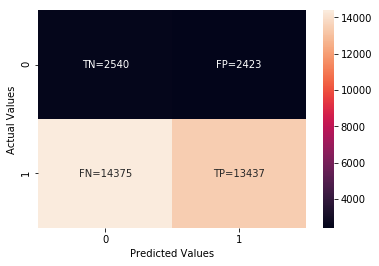

In [41]:

print("AUC on Test Data using Random Model",roc_auc_score(y_test, predicted_y[:,1]))

#obtaining fpr, tpr, thresholds using roc_curve function
test_fpr, test_tpr, test_thresholds = metrics.roc_curve(y_test, predicted_y[:,1]);

#obtaining 0 or 1, using probability (predicted_y) and our defind predict functio

pred_y = predict(predicted_y[:, 1], test_thresholds, test_fpr, test_tpr)

#plotting confusion matrix
plot_confusion_matrix(y_test, pred_y);

So the worst AUC we found using random model is 0.496, now we'll take it as base AUC to compare AUC with other models.

<h2>Logistic Regression on text featurized using tfidf</h2>

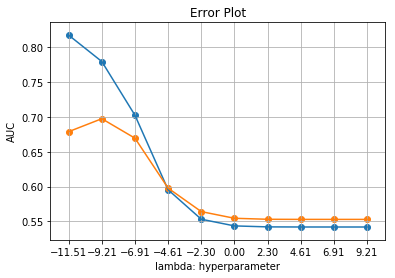

In [42]:

#creating list for holding auc value for train, cv
train_auc = [];
cv_auc = [];

#defining list of lambda's
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000];

for a in alpha:
    #using SGDClassifier, and passing log in loss, which makes it LogisticRegression
    LR = SGDClassifier(loss='log', penalty='l2', alpha=a); #usig L2 Regularization
    LR.fit(train_tfidf, y_train); #training model using training data.
    
    y_train_pred = LR.predict_proba(train_tfidf)[:, 1]; #predicting probability for training data
    y_cv_pred = LR.predict_proba(cv_tfidf)[:, 1]; #predicting probability for cv data
    
    train_auc.append(roc_auc_score(y_train, y_train_pred));
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred));
    
#plotting error plot
plt.plot(np.log(alpha), train_auc, label='Train AUC');
plt.plot(np.log(alpha), cv_auc, label='CV AUC');

plt.scatter(np.log(alpha), train_auc, label='Train AUC points');
plt.scatter(np.log(alpha), cv_auc, label='CV AUC points');
    
plt.xlabel('lambda: hyperparameter');
plt.ylabel('AUC');
plt.title('Error Plot');

plt.xticks(np.log(alpha))

plt.grid();
plt.show()

0.001


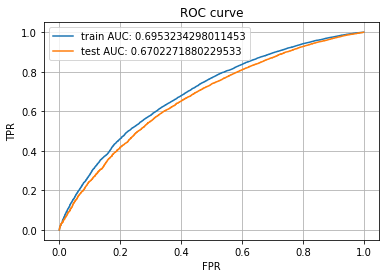

In [43]:
optimal_alpha = 0.001
tfidf_lr_alpha = optimal_alpha;
print(optimal_alpha)
#training model using optimal_alpha
LR = SGDClassifier(loss='log', penalty='l2', alpha=optimal_alpha);

LR.fit(train_tfidf, y_train);

y_train_pred = LR.predict_proba(train_tfidf)[:, 1];
y_test_pred = LR.predict_proba(test_tfidf)[:, 1];

train_fpr, train_tpr, train_thresholds = metrics.roc_curve(y_train, y_train_pred);
test_fpr, test_tpr, test_thresholds = metrics.roc_curve(y_test, y_test_pred);

train_auc = roc_auc_score(y_train, y_train_pred);
test_auc = roc_auc_score(y_test, y_test_pred);

tfidf_lr_auc = test_auc;

#plotting ROC curve
plt.plot(train_fpr, train_tpr, label="train AUC: "+str(train_auc))
plt.plot(test_fpr, test_tpr, label="test AUC: "+str(test_auc))


plt.grid();
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.legend();
plt.show()

Here we obtained AUC = 0.66 using Logistic Regression(where text featurized using tfidf), which is better than random model

Train confusion matrix: 
the maximum value of tpr*(1-fpr) 0.4121819100791349 for threshold 0.838


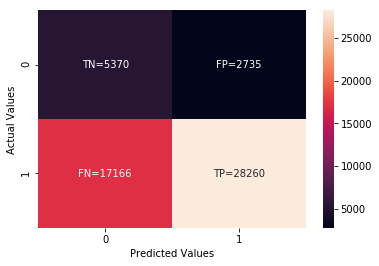

In [44]:
print('Train confusion matrix: ');
train_pred = predict(y_train_pred, train_thresholds, train_fpr, train_tpr);
plot_confusion_matrix(y_train, train_pred);

Test confusion matrix: 
the maximum value of tpr*(1-fpr) 0.4121819100791349 for threshold 0.838


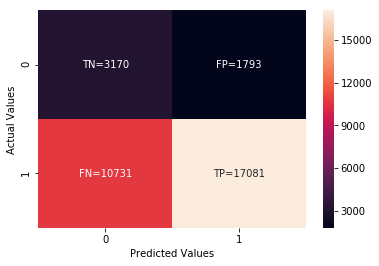

In [45]:
print('Test confusion matrix: ');
test_pred = predict(y_test_pred, train_thresholds, train_fpr, train_tpr);
plot_confusion_matrix(y_test, test_pred);

<h2>Logistic Regression on text featurized using avg w2v</h2>

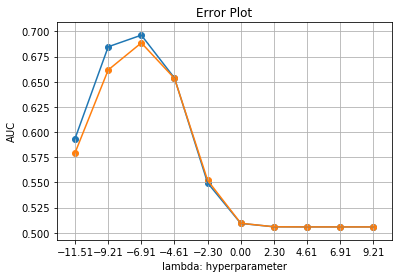

In [46]:

#creating list for holding auc value for train, cv
train_auc = [];
cv_auc = [];

#defining list of lambda's
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000];

for a in alpha:
    #using SGDClassifier, and passing log in loss, which makes it LogisticRegression
    LR = SGDClassifier(loss='log', penalty='l2', alpha=a); #usig L2 Regularization
    LR.fit(train_w2v, y_train); #training model using training data.
    
    y_train_pred = LR.predict_proba(train_w2v)[:, 1]; #predicting probability for training data
    y_cv_pred = LR.predict_proba(cv_w2v)[:, 1]; #predicting probability for cv data
    
    train_auc.append(roc_auc_score(y_train, y_train_pred));
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred));
    
#plotting error plot
plt.plot(np.log(alpha), train_auc, label='Train AUC');
plt.plot(np.log(alpha), cv_auc, label='CV AUC');

plt.scatter(np.log(alpha), train_auc, label='Train AUC points');
plt.scatter(np.log(alpha), cv_auc, label='CV AUC points');
    
plt.xlabel('lambda: hyperparameter');
plt.ylabel('AUC');
plt.title('Error Plot');

plt.xticks(np.log(alpha))

plt.grid();
plt.show()

0.001


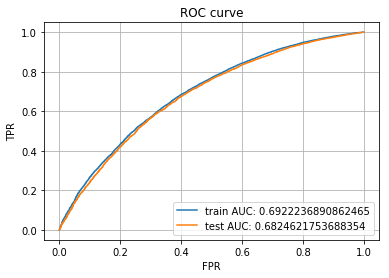

In [47]:
optimal_alpha = 0.001
w2v_lr_alpha = optimal_alpha;
print(optimal_alpha)
#training model using optimal_alpha
LR = SGDClassifier(loss='log', penalty='l2', alpha=optimal_alpha);

LR.fit(train_w2v, y_train);

y_train_pred = LR.predict_proba(train_w2v)[:, 1];
y_test_pred = LR.predict_proba(test_w2v)[:, 1];

train_fpr, train_tpr, train_thresholds = metrics.roc_curve(y_train, y_train_pred);
test_fpr, test_tpr, test_thresholds = metrics.roc_curve(y_test, y_test_pred);

train_auc = roc_auc_score(y_train, y_train_pred);
test_auc = roc_auc_score(y_test, y_test_pred);

w2v_lr_auc = test_auc;

#plotting ROC curve
plt.plot(train_fpr, train_tpr, label="train AUC: "+str(train_auc))
plt.plot(test_fpr, test_tpr, label="test AUC: "+str(test_auc))


plt.grid();
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.legend();
plt.show()

Obtained AUC is 0.66 using Logistic Regression(where text featurization is done using avg w2v), which is better than random model

Train confusion matrix: 
the maximum value of tpr*(1-fpr) 0.41204023937026285 for threshold 0.838


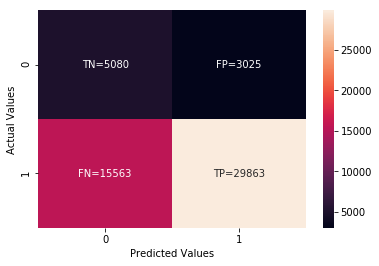

In [48]:
print('Train confusion matrix: ');
train_pred = predict(y_train_pred, train_thresholds, train_fpr, train_tpr);
plot_confusion_matrix(y_train, train_pred);

Test confusion matrix: 
the maximum value of tpr*(1-fpr) 0.41204023937026285 for threshold 0.838


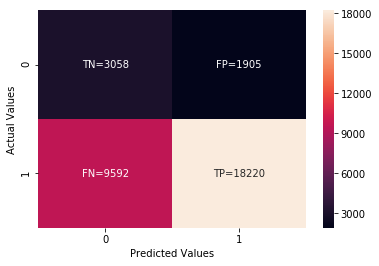

In [49]:
print('Test confusion matrix: ');
test_pred = predict(y_test_pred, train_thresholds, train_fpr, train_tpr);
plot_confusion_matrix(y_test, test_pred);

<h2>Logistic Regression on text featurized using tfidf avg w2v</h2>

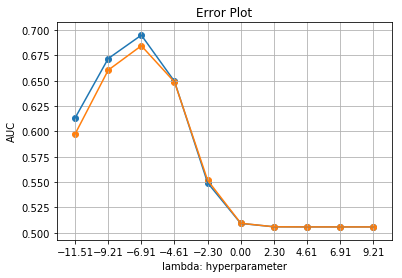

In [52]:

#creating list for holding auc value for train, cv
train_auc = [];
cv_auc = [];

#defining list of lambda's
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000];

for a in alpha:
    #using SGDClassifier, and passing log in loss, which makes it LogisticRegression
    LR = SGDClassifier(loss='log', penalty='l2', alpha=a); #usig L2 Regularization
    LR.fit(train_tfidf_w2v, y_train); #training model using training data.
    
    y_train_pred = LR.predict_proba(train_tfidf_w2v)[:, 1]; #predicting probability for training data
    y_cv_pred = LR.predict_proba(cv_tfidf_w2v)[:, 1]; #predicting probability for cv data
    
    train_auc.append(roc_auc_score(y_train, y_train_pred));
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred));
    
#plotting error plot
plt.plot(np.log(alpha), train_auc, label='Train AUC');
plt.plot(np.log(alpha), cv_auc, label='CV AUC');

plt.scatter(np.log(alpha), train_auc, label='Train AUC points');
plt.scatter(np.log(alpha), cv_auc, label='CV AUC points');
    
plt.xlabel('lambda: hyperparameter');
plt.ylabel('AUC');
plt.title('Error Plot');

plt.xticks(np.log(alpha))

plt.grid();
plt.show()

0.001


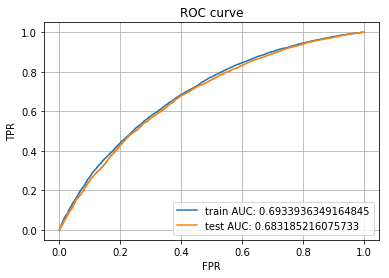

In [53]:
optimal_alpha = 0.001
tfidf_w2v_lr_alpha = optimal_alpha;
print(optimal_alpha)
#training model using optimal_alpha
LR = SGDClassifier(loss='log', penalty='l2', alpha=optimal_alpha);

LR.fit(train_tfidf_w2v, y_train);

y_train_pred = LR.predict_proba(train_tfidf_w2v)[:, 1];
y_test_pred = LR.predict_proba(test_tfidf_w2v)[:, 1];

train_fpr, train_tpr, train_thresholds = metrics.roc_curve(y_train, y_train_pred);
test_fpr, test_tpr, test_thresholds = metrics.roc_curve(y_test, y_test_pred);

train_auc = roc_auc_score(y_train, y_train_pred);
test_auc = roc_auc_score(y_test, y_test_pred);

tfidf_w2v_lr_auc = test_auc;

#plotting ROC curve
plt.plot(train_fpr, train_tpr, label="train AUC: "+str(train_auc))
plt.plot(test_fpr, test_tpr, label="test AUC: "+str(test_auc))


plt.grid();
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.legend();
plt.show()

Obtained AUC is 0.68 using Logistic Regression(where text featurization is done using tfidf wt w2v), which is better than random model

Train confusion matrix: 
the maximum value of tpr*(1-fpr) 0.41225459236765893 for threshold 0.892


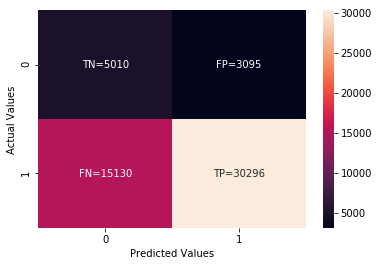

In [54]:
print('Train confusion matrix: ');
train_pred = predict(y_train_pred, train_thresholds, train_fpr, train_tpr);
plot_confusion_matrix(y_train, train_pred);

Test confusion matrix: 
the maximum value of tpr*(1-fpr) 0.41225459236765893 for threshold 0.892


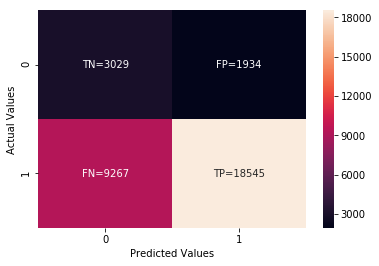

In [55]:
print('Test confusion matrix: ');
test_pred = predict(y_test_pred, train_thresholds, train_fpr, train_tpr);
plot_confusion_matrix(y_test, test_pred);

<h2>Random Forest on text featurized using tfidf</h2>

In [56]:

tuned_parameters=[{'max_depth': [10, 50, 100, 500, 1000], 'n_estimators': [5, 10, 100, 500, 1000]}]

RF = RandomForestClassifier(n_jobs = -1, random_state = 23, class_weight="balanced_subsample");

model = GridSearchCV(RF, tuned_parameters, scoring = 'roc_auc', cv=8, n_jobs = -1 )

model.fit(train_tfidf, y_train);

print(model.best_estimator_)
print(model.score(cv_tfidf, y_cv))

RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_depth=100, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=-1, oob_score=False, random_state=23,
            verbose=0, warm_start=False)
0.7056167057547694


In [57]:


#creating list for holding auc value for train, cv
train_auc = [];
cv_auc = [];

#defining list of alpha's
max_depth = [1, 5, 10, 50, 100, 500, 1000];
n_estimators  = [5, 10, 100, 500, 1000];

for estimator in n_estimators:
    train_auc_temp = [];
    cv_auc_temp = [];
    for d in max_depth:
        RF = RandomForestClassifier(max_depth = d, n_estimators = estimator, n_jobs = -1, random_state = 23, class_weight="balanced_subsample");
        RF.fit(train_tfidf, y_train);
        
        y_train_pred = RF.predict_proba(train_tfidf)[:, 1];
        y_cv_pred = RF.predict_proba(cv_tfidf)[:, 1];
        
        train_auc_temp.append(roc_auc_score(y_train, y_train_pred));
        cv_auc_temp.append(roc_auc_score(y_cv, y_cv_pred));

    train_auc.append(train_auc_temp);
    cv_auc.append(cv_auc_temp);
       

Text(159,0.5,'n_estimators')

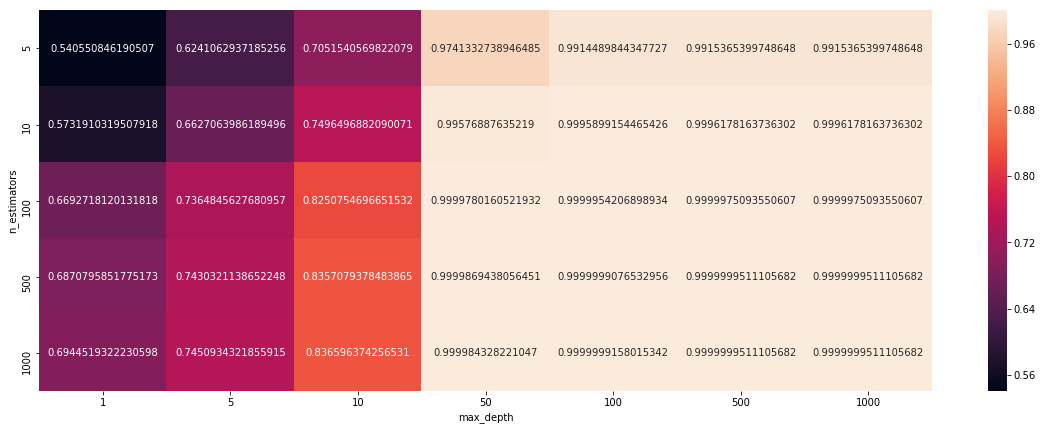

In [58]:
plt.figure(figsize=(20,7))
sns.heatmap(train_auc,  annot=True, fmt='', yticklabels=n_estimators, xticklabels=max_depth);
plt.xlabel("max_depth");
plt.ylabel("n_estimators")

Text(159,0.5,'n_estimators')

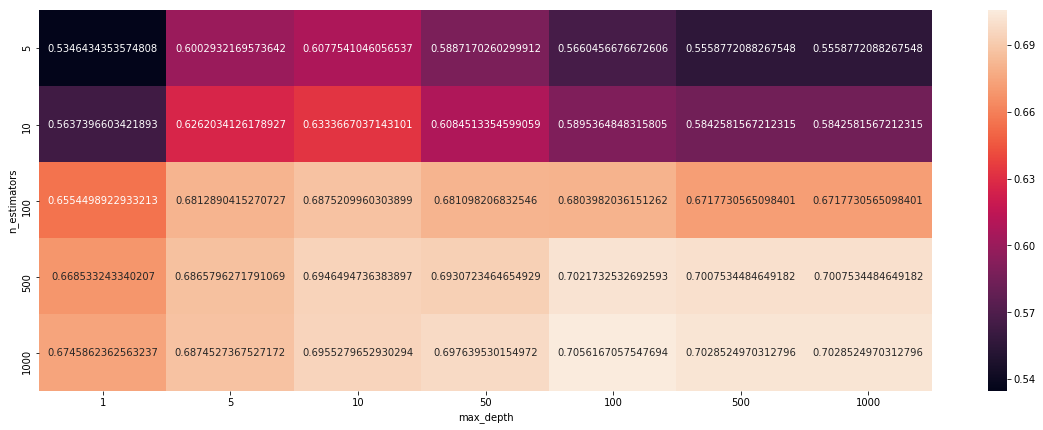

In [59]:
plt.figure(figsize=(20,7))
sns.heatmap(cv_auc,  annot=True, fmt='', yticklabels=n_estimators, xticklabels=max_depth);
plt.xlabel("max_depth");
plt.ylabel("n_estimators")

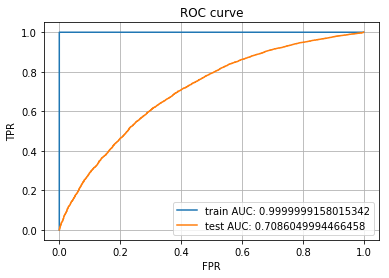

In [60]:

#obtained optimal values 
set2_max_depth = 100;
set2_n_estimators = 1000;

RF = RandomForestClassifier(max_depth = set2_max_depth, n_estimators = set2_n_estimators, n_jobs = -1, random_state = 23, class_weight="balanced_subsample");
RF.fit(train_tfidf, y_train);

y_train_pred = RF.predict_proba(train_tfidf)[:, 1];
y_test_pred = RF.predict_proba(test_tfidf)[:, 1];

#obtaining auc value
train_auc = roc_auc_score(y_train, y_train_pred);
test_auc = roc_auc_score(y_test, y_test_pred);
tfidf_rf_auc = test_auc;

#obtaining fpr, tpr and thresholds
train_fpr, train_tpr, train_thresholds = metrics.roc_curve(y_train, y_train_pred);
test_fpr, test_tpr, test_thresholds = metrics.roc_curve(y_test, y_test_pred);

#plotting ROC curve
plt.plot(train_fpr, train_tpr, label="train AUC: "+str(train_auc))
plt.plot(test_fpr, test_tpr, label="test AUC: "+str(test_auc))


plt.grid();
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.legend();
plt.show()


Train confusion matrix: 
the maximum value of tpr*(1-fpr) 0.9998679170519086 for threshold 0.635


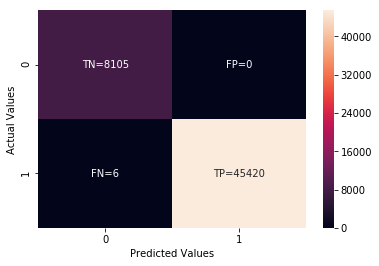

In [61]:
print('Train confusion matrix: ');
train_pred = predict(y_train_pred, train_thresholds, train_fpr, train_tpr);
plot_confusion_matrix(y_train, train_pred);

Test confusion matrix: 
the maximum value of tpr*(1-fpr) 0.9998679170519086 for threshold 0.635


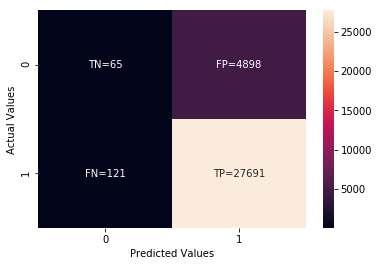

In [62]:
print('Test confusion matrix: ');
test_pred = predict(y_test_pred, train_thresholds, train_fpr, train_tpr);
plot_confusion_matrix(y_test, test_pred);

<h2>Random Forest on text featurized using avg w2v</h2>

In [44]:

#creating list for holding auc value for train, cv
train_auc = [];
cv_auc = [];

#defining list of alpha's
max_depth = [1, 5, 10, 50, 100, 500, 1000];
n_estimators  = [5, 10, 100, 500, 1000];

for estimator in n_estimators:
    train_auc_temp = [];
    cv_auc_temp = [];
    for d in max_depth:
        RF = RandomForestClassifier(max_depth = d, n_estimators = estimator, n_jobs = -1, random_state = 23, class_weight="balanced_subsample");
        RF.fit(train_w2v, y_train);
        
        y_train_pred = RF.predict_proba(train_w2v)[:, 1];
        y_cv_pred = RF.predict_proba(cv_w2v)[:, 1];
        
        train_auc_temp.append(roc_auc_score(y_train, y_train_pred));
        cv_auc_temp.append(roc_auc_score(y_cv, y_cv_pred));

    train_auc.append(train_auc_temp);
    cv_auc.append(cv_auc_temp);
       

Text(159.0, 0.5, 'n_estimators')

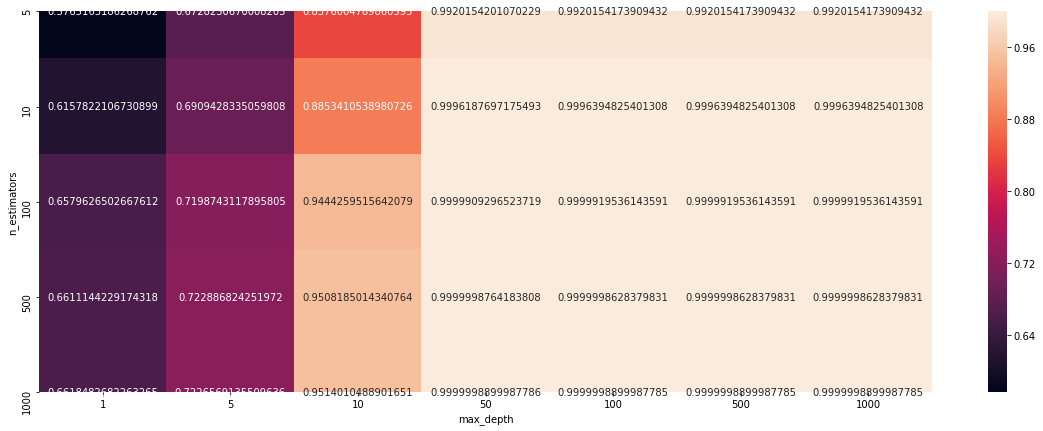

In [45]:
plt.figure(figsize=(20,7))
sns.heatmap(train_auc,  annot=True, fmt='', yticklabels=n_estimators, xticklabels=max_depth);
plt.xlabel("max_depth");
plt.ylabel("n_estimators")

Text(159.0, 0.5, 'n_estimators')

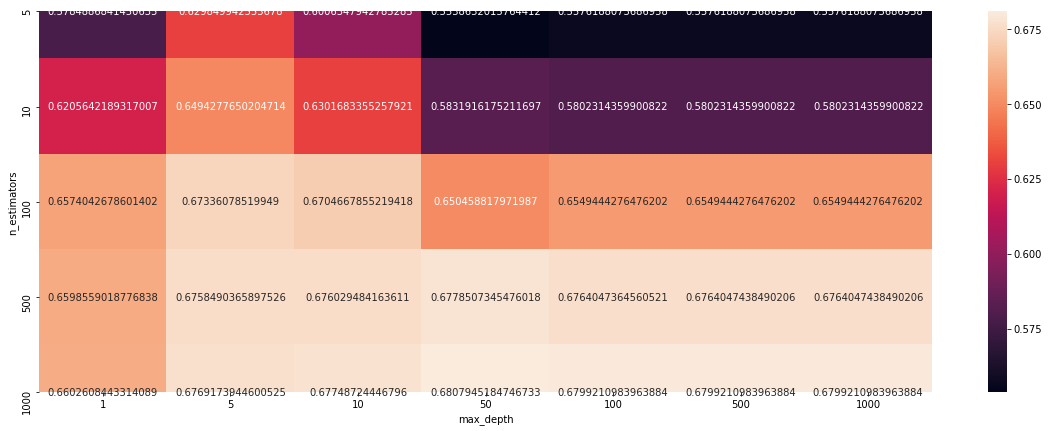

In [46]:
plt.figure(figsize=(20,7))
sns.heatmap(cv_auc,  annot=True, fmt='', yticklabels=n_estimators, xticklabels=max_depth);
plt.xlabel("max_depth");
plt.ylabel("n_estimators")

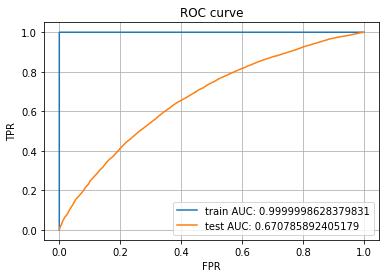

In [66]:

#obtained optimal values 
set2_max_depth = 1000;
set2_n_estimators = 500;

RF = RandomForestClassifier(max_depth = set2_max_depth, n_estimators = set2_n_estimators, n_jobs = -1, random_state = 23, class_weight="balanced_subsample");
RF.fit(train_w2v, y_train);

y_train_pred = RF.predict_proba(train_w2v)[:, 1];
y_test_pred = RF.predict_proba(test_w2v)[:, 1];

#obtaining auc value
train_auc = roc_auc_score(y_train, y_train_pred);
test_auc = roc_auc_score(y_test, y_test_pred);
w2v_rf_auc = test_auc;

#obtaining fpr, tpr and thresholds
train_fpr, train_tpr, train_thresholds = metrics.roc_curve(y_train, y_train_pred);
test_fpr, test_tpr, test_thresholds = metrics.roc_curve(y_test, y_test_pred);

#plotting ROC curve
plt.plot(train_fpr, train_tpr, label="train AUC: "+str(train_auc))
plt.plot(test_fpr, test_tpr, label="test AUC: "+str(test_auc))


plt.grid();
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.legend();
plt.show()


Train confusion matrix: 
the maximum value of tpr*(1-fpr) 0.9998018755778629 for threshold 0.722


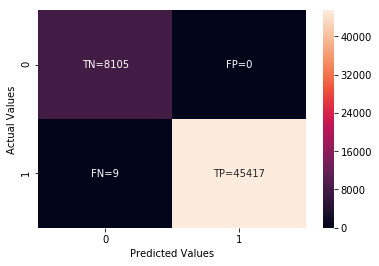

In [67]:
print('Train confusion matrix: ');
train_pred = predict(y_train_pred, train_thresholds, train_fpr, train_tpr);
plot_confusion_matrix(y_train, train_pred);

Test confusion matrix: 
the maximum value of tpr*(1-fpr) 0.9998018755778629 for threshold 0.722


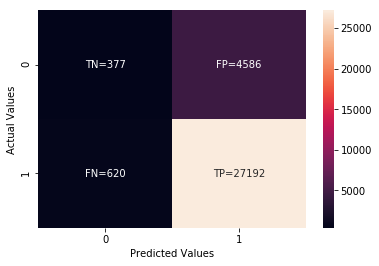

In [68]:
print('Test confusion matrix: ');
test_pred = predict(y_test_pred, train_thresholds, train_fpr, train_tpr);
plot_confusion_matrix(y_test, test_pred);

<h2>Random Forest on text featurized using tfidf wt w2v</h2>

In [70]:

#creating list for holding auc value for train, cv
train_auc = [];
cv_auc = [];

#defining list of alpha's
max_depth = [1, 5, 10, 50, 100, 500, 1000];
n_estimators  = [5, 10, 100, 500, 1000];

for estimator in n_estimators:
    train_auc_temp = [];
    cv_auc_temp = [];
    for d in max_depth:
        RF = RandomForestClassifier(max_depth = d, n_estimators = estimator, n_jobs = -1, random_state = 23, class_weight="balanced_subsample");
        RF.fit(train_tfidf_w2v, y_train);
        
        y_train_pred = RF.predict_proba(train_tfidf_w2v)[:, 1];
        y_cv_pred = RF.predict_proba(cv_tfidf_w2v)[:, 1];
        
        train_auc_temp.append(roc_auc_score(y_train, y_train_pred));
        cv_auc_temp.append(roc_auc_score(y_cv, y_cv_pred));

    train_auc.append(train_auc_temp);
    cv_auc.append(cv_auc_temp);
       

Text(159,0.5,'n_estimators')

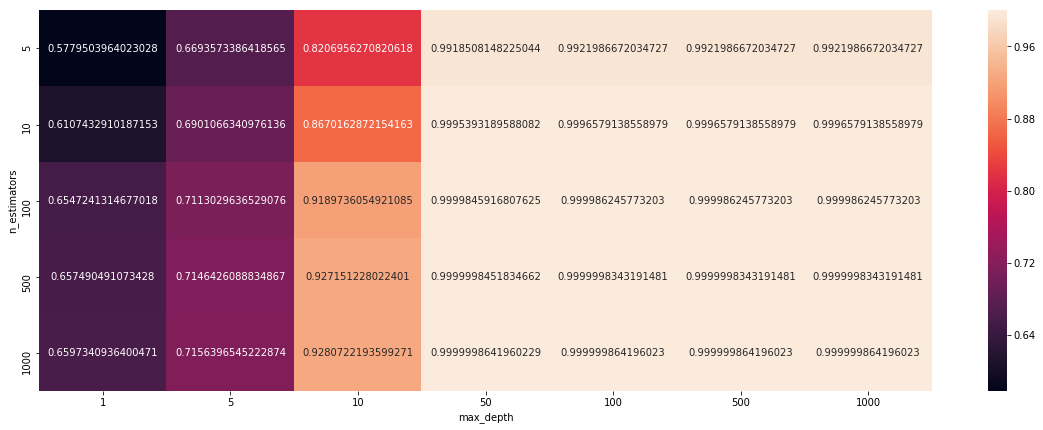

In [72]:
plt.figure(figsize=(20,7))
sns.heatmap(train_auc,  annot=True, fmt='', yticklabels=n_estimators, xticklabels=max_depth);
plt.xlabel("max_depth");
plt.ylabel("n_estimators")

Text(159,0.5,'n_estimators')

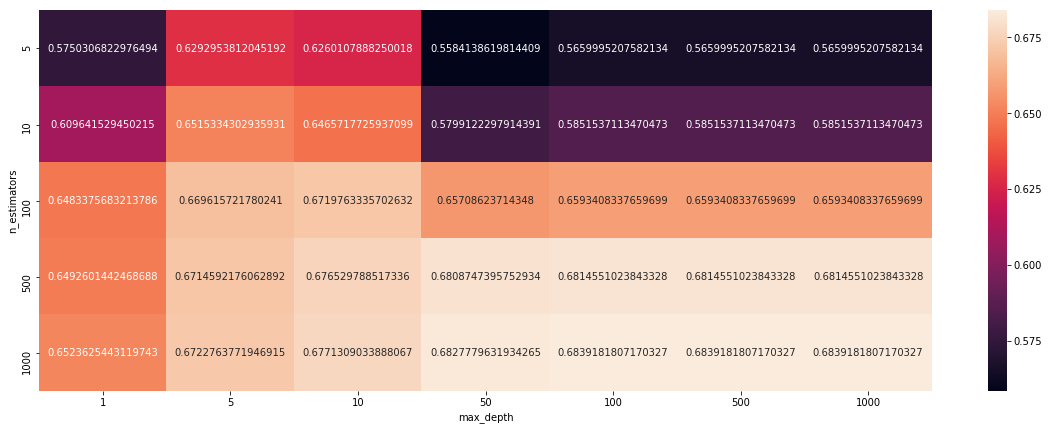

In [73]:
plt.figure(figsize=(20,7))
sns.heatmap(cv_auc,  annot=True, fmt='', yticklabels=n_estimators, xticklabels=max_depth);
plt.xlabel("max_depth");
plt.ylabel("n_estimators")

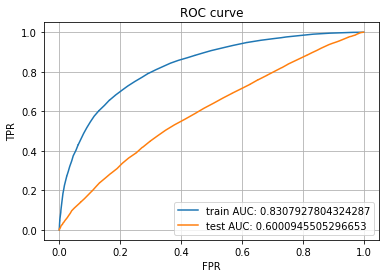

In [74]:

#obtained optimal values 
set3_max_depth = 1000;
set3_n_estimators = 500;

RF = RandomForestClassifier(max_depth = set3_max_depth, n_estimators = set3_n_estimators, n_jobs = -1, random_state = 23, class_weight="balanced_subsample");
RF.fit(train_w2v, y_train);

y_train_pred = RF.predict_proba(train_tfidf_w2v)[:, 1];
y_test_pred = RF.predict_proba(test_tfidf_w2v)[:, 1];

#obtaining auc value
train_auc = roc_auc_score(y_train, y_train_pred);
test_auc = roc_auc_score(y_test, y_test_pred);
tfidf_w2v_rf_auc = test_auc;

#obtaining fpr, tpr and thresholds
train_fpr, train_tpr, train_thresholds = metrics.roc_curve(y_train, y_train_pred);
test_fpr, test_tpr, test_thresholds = metrics.roc_curve(y_test, y_test_pred);

#plotting ROC curve
plt.plot(train_fpr, train_tpr, label="train AUC: "+str(train_auc))
plt.plot(test_fpr, test_tpr, label="test AUC: "+str(test_auc))


plt.grid();
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.legend();
plt.show()


Train confusion matrix: 
the maximum value of tpr*(1-fpr) 0.5649353642329209 for threshold 0.843


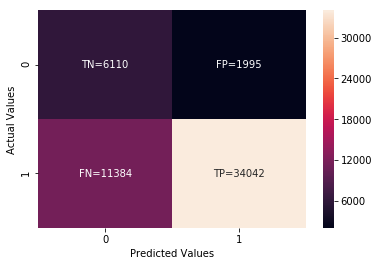

In [75]:
print('Train confusion matrix: ');
train_pred = predict(y_train_pred, train_thresholds, train_fpr, train_tpr);
plot_confusion_matrix(y_train, train_pred);

Test confusion matrix: 
the maximum value of tpr*(1-fpr) 0.5649353642329209 for threshold 0.843


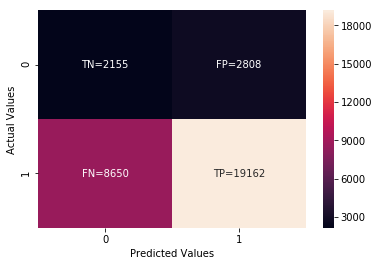

In [76]:
print('Test confusion matrix: ');
test_pred = predict(y_test_pred, train_thresholds, train_fpr, train_tpr);
plot_confusion_matrix(y_test, test_pred);

In [77]:

from prettytable import PrettyTable

table = PrettyTable();
table.field_names = ['Vectorizer', 'Model', 'AUC'];

table.add_row(['TFIDF', 'Logistic Regression', tfidf_lr_auc]);
table.add_row(['W2V', 'Logistic Regression',  w2v_lr_auc]);
table.add_row(['TFIDF wt. W2V', 'Logistic Regression',  tfidf_w2v_lr_auc]);
table.add_row(['TFIDF', 'Random Forest',  tfidf_rf_auc]);
table.add_row(['W2V', 'Random Forest',  w2v_rf_auc]);
table.add_row(['TFIDF wt. W2V', 'Random Forest',  tfidf_w2v_rf_auc]);
print(table)

+---------------+---------------------+--------------------+
|   Vectorizer  |        Model        |        AUC         |
+---------------+---------------------+--------------------+
|     TFIDF     | Logistic Regression | 0.6702271880229533 |
|      W2V      | Logistic Regression | 0.6824621753688354 |
| TFIDF wt. W2V | Logistic Regression | 0.683185216075733  |
|     TFIDF     |    Random Forest    | 0.7086049994466458 |
|      W2V      |    Random Forest    | 0.670785892405179  |
| TFIDF wt. W2V |    Random Forest    | 0.6000945505296653 |
+---------------+---------------------+--------------------+


## Observation:
- we are getting maximum AUC using Random Forest when text featurization performed using TFIDF Vectorizer.